## KRILLBASE

KRILLBASE contains pontual records of the post-larval krill density. The data were collected from 1929 to 2016.
We aggregate the krill records on a spatial grid of a resolution of 2°x2° degres // or 0.25°x0.25° like KRILLPODYM resolution.

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import sem
import math
import datetime
import time

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os
#os.chdir('./Key_Areas_krill_carbon_sequestration/data_envir')

Cannot find header.dxf (GDAL_DATA is not defined)


### Load the KRILLBASE data

In [2]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/')

krill_base = pd.read_excel('./data_envir/krillbase_data.xlsx')
krill_base # 14 734 rows × 29 columns

,STATION,RECORD_TYPE,NUMBER_OF_STATIONS,NUMBER_OF_NETS,LATITUDE,LONGITUDE,SEASON,DAYS_FROM_1ST_OCT,DATE,DATE_ACCURACY,...,N_OR_S_POLAR_FRONT,WATER_DEP_MEAN_WITHIN_10KM,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,SD_OF_SURVEY_MEAN_KRILL,NUMBER_OF_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2,CAVEATS,NUMBER_OF_SALPS_UNDER_1M2,SOURCE
0,ake2008sars16,haul,1.0,1.0,-51.9880,-25.0040,2008.0,107.0,2008-01-15,M,...,S,3602.732673,763.0,4.298100,NaN,0.087508,0.116,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
1,ake2008sars17,haul,1.0,1.0,-52.3310,-18.1600,2008.0,107.0,2008-01-15,M,...,N,4231.476285,143.0,3.819259,NaN,0.000000,0.000,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
2,ake2008sars22,haul,1.0,1.0,-57.5340,-7.4940,2008.0,107.0,2008-01-15,M,...,S,2726.067327,1427.0,1.036612,NaN,0.485498,1.454,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
3,ake2008sars23,haul,1.0,1.0,-58.7590,-6.2200,2008.0,107.0,2008-01-15,M,...,S,3905.786982,1299.0,0.807276,NaN,12.948638,38.784,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
4,ake2008sars24,haul,1.0,1.0,-58.7590,-0.0370,2008.0,107.0,2008-01-15,M,...,S,4391.713439,428.0,0.833557,NaN,101.965050,305.411,Warning: exact date not known.,NaN,"Norwegian data (AKES cruise), B. Kraffts pers...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,vsi2004lak1113,haul,1.0,1.0,-62.0000,-1.9833,2004.0,208.0,2004-04-25,D,...,S,5270.206759,384.0,0.786577,NaN,0.000000,0.000,NaN,0.000000,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14730,vsi2004lak1114,haul,1.0,1.0,-62.3167,-2.0000,2004.0,208.0,2004-04-25,D,...,S,5299.237154,131.0,0.786506,NaN,16.387810,68.804,NaN,0.000000,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14731,vsi2004lak1115,haul,1.0,1.0,-62.6667,-2.0167,2004.0,209.0,2004-04-26,D,...,S,5241.013889,120.0,0.784432,NaN,12.094240,52.062,Warning: winter sample date.,0.086853,"German data (LAKRIS cruise), V. Siegel, pers. ..."
14732,vsi2004lak1116,haul,1.0,1.0,-63.0000,-2.0000,2004.0,209.0,2004-04-26,D,...,S,5205.778443,73.0,0.778599,NaN,23.064810,99.287,Warning: winter sample date.,0.557238,"German data (LAKRIS cruise), V. Siegel, pers. ..."


# Procedure to clean KRILLBASE
KRILLBASE data are cleaned following these steps:
1. Select columns of interest in the initial data set 
2. Select records from 1976
3. Filter NaN in standardized density of krill
4. Filter records with shallowest sampling depth <20m and deepest sampling depth > 50m
5. Filter for summer data (all standardized data should be between October and March included)
6. Filter for records south of the polar front

In [3]:
# 1. interest columns
krill_base = krill_base[['STATION', 'RECORD_TYPE', 'DATE', 'DATE_ACCURACY', 
                'LATITUDE', 'LONGITUDE',
                'N_OR_S_POLAR_FRONT',
                'TOP_SAMPLING_DEPTH_M', 'BOTTOM_SAMPLING_DEPTH_M',
                'STANDARDISED_KRILL_UNDER_1M2',
                'NUMBER_OF_KRILL_UNDER_1M2',
                'WATER_DEP_MEAN_WITHIN_10KM',
                'WATER_DEPTH_RANGE_WITHIN_10KM',
                'CLIMATOLOGICAL_TEMPERATURE']]

# 2. create new columns to store Year and Month of the records
krill_base['DATE'] = pd.to_datetime(krill_base.DATE)
krill_base['YEAR'] = krill_base['DATE'].dt.year
krill_base['MONTH'] = krill_base['DATE'].dt.month

# 3. Filter NaN in standardized density of krill
krill_base = krill_base.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2']) # 10102 

# 4. Filter for depth of sampling <20m and > 50m and removes "survey means" and "stratified hauls"
krill_base = krill_base[(krill_base['RECORD_TYPE'] == 'haul') | (krill_base['RECORD_TYPE'] == 'stratified pooled haul')]
krill_base = krill_base[(krill_base['TOP_SAMPLING_DEPTH_M'] < 20) & (krill_base['BOTTOM_SAMPLING_DEPTH_M'] > 50)] # 9425 

# 5. Filter for summer data (all standardized data should be between October and March included)
krill_base = krill_base[(krill_base['MONTH'] >= 10) | (krill_base['MONTH'] <= 3)] #  

# 6. Filter south of polar front
krill_base = krill_base[krill_base['N_OR_S_POLAR_FRONT'] == 'S'] 
krill_base #  10431 


C:\Users\anael\AppData\Local\Temp\ipykernel_36832\1476309236.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krill_base['DATE'] = pd.to_datetime(krill_base.DATE)
C:\Users\anael\AppData\Local\Temp\ipykernel_36832\1476309236.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  krill_base['YEAR'] = krill_base['DATE'].dt.year
C:\Users\anael\AppData\Local\Temp\ipykernel_36832\1476309236.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

,STATION,RECORD_TYPE,DATE,DATE_ACCURACY,LATITUDE,LONGITUDE,N_OR_S_POLAR_FRONT,TOP_SAMPLING_DEPTH_M,BOTTOM_SAMPLING_DEPTH_M,STANDARDISED_KRILL_UNDER_1M2,NUMBER_OF_KRILL_UNDER_1M2,WATER_DEP_MEAN_WITHIN_10KM,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,YEAR,MONTH
0,ake2008sars16,haul,2008-01-15,M,-51.9880,-25.0040,S,0.0,771.0,0.116,0.087508,3602.732673,763.0,4.298100,2008.0,1.0
2,ake2008sars22,haul,2008-01-15,M,-57.5340,-7.4940,S,0.0,757.0,1.454,0.485498,2726.067327,1427.0,1.036612,2008.0,1.0
3,ake2008sars23,haul,2008-01-15,M,-58.7590,-6.2200,S,0.0,760.0,38.784,12.948638,3905.786982,1299.0,0.807276,2008.0,1.0
4,ake2008sars24,haul,2008-01-15,M,-58.7590,-0.0370,S,0.0,790.0,305.411,101.965050,4391.713439,428.0,0.833557,2008.0,1.0
5,ake2008sars25,haul,2008-02-14,M,-56.2070,-0.0530,S,0.0,750.0,186.117,50.631877,3735.085657,1367.0,0.996215,2008.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14636,vsi2001ste82,haul,2001-01-28,D,-61.5000,-54.1833,S,0.0,194.0,3.188,1.241600,712.455621,861.0,0.719545,2001.0,1.0
14637,vsi2001ste83,haul,2001-01-28,D,-61.7500,-54.2167,S,0.0,196.0,0.483,0.188160,446.390963,608.0,0.719545,2001.0,1.0
14638,vsi2001ste93,haul,2001-01-28,D,-62.0000,-54.0000,S,0.0,197.0,15.162,5.900150,556.061265,243.0,0.436525,2001.0,1.0
14639,vsi2001ste95,haul,2001-01-29,D,-62.0667,-55.0500,S,0.0,206.0,20.091,7.757960,852.482283,998.0,0.586243,2001.0,1.0


# Spatial Aggregation of the krill records

In [4]:
# round the coordinated of the data 
def round_acc(x, accuracy):
    return round(x / accuracy) * accuracy

def round_coord_ocim(y) :
    if np.trunc(y) % 2 == 0 : # if integer part is even
        return(np.trunc(y)+1)
    else :
        return(np.trunc(y))
    

# add lat long of OICM grid
krill_base['LONGITUDE_ocimgrid'] = krill_base['LONGITUDE'].apply(round_coord_ocim)
krill_base['LATITUDE_ocimgrid'] = krill_base['LATITUDE'].apply(round_coord_ocim)

#add lat long of 2x6° grid
krill_base['LONGITUDE_largegrid'] = krill_base['LONGITUDE'].apply(lambda x: round_acc(x, accuracy=6))
krill_base['LATITUDE_largegrid'] = krill_base['LATITUDE'].apply(round_coord_ocim)

krill_base 

,STATION,RECORD_TYPE,DATE,DATE_ACCURACY,LATITUDE,LONGITUDE,N_OR_S_POLAR_FRONT,TOP_SAMPLING_DEPTH_M,BOTTOM_SAMPLING_DEPTH_M,STANDARDISED_KRILL_UNDER_1M2,NUMBER_OF_KRILL_UNDER_1M2,WATER_DEP_MEAN_WITHIN_10KM,WATER_DEPTH_RANGE_WITHIN_10KM,CLIMATOLOGICAL_TEMPERATURE,YEAR,MONTH,LONGITUDE_ocimgrid,LATITUDE_ocimgrid,LONGITUDE_largegrid,LATITUDE_largegrid
0,ake2008sars16,haul,2008-01-15,M,-51.9880,-25.0040,S,0.0,771.0,0.116,0.087508,3602.732673,763.0,4.298100,2008.0,1.0,-25.0,-51.0,-24,-51.0
2,ake2008sars22,haul,2008-01-15,M,-57.5340,-7.4940,S,0.0,757.0,1.454,0.485498,2726.067327,1427.0,1.036612,2008.0,1.0,-7.0,-57.0,-6,-57.0
3,ake2008sars23,haul,2008-01-15,M,-58.7590,-6.2200,S,0.0,760.0,38.784,12.948638,3905.786982,1299.0,0.807276,2008.0,1.0,-5.0,-57.0,-6,-57.0
4,ake2008sars24,haul,2008-01-15,M,-58.7590,-0.0370,S,0.0,790.0,305.411,101.965050,4391.713439,428.0,0.833557,2008.0,1.0,1.0,-57.0,0,-57.0
5,ake2008sars25,haul,2008-02-14,M,-56.2070,-0.0530,S,0.0,750.0,186.117,50.631877,3735.085657,1367.0,0.996215,2008.0,2.0,1.0,-55.0,0,-55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14636,vsi2001ste82,haul,2001-01-28,D,-61.5000,-54.1833,S,0.0,194.0,3.188,1.241600,712.455621,861.0,0.719545,2001.0,1.0,-53.0,-61.0,-54,-61.0
14637,vsi2001ste83,haul,2001-01-28,D,-61.7500,-54.2167,S,0.0,196.0,0.483,0.188160,446.390963,608.0,0.719545,2001.0,1.0,-53.0,-61.0,-54,-61.0
14638,vsi2001ste93,haul,2001-01-28,D,-62.0000,-54.0000,S,0.0,197.0,15.162,5.900150,556.061265,243.0,0.436525,2001.0,1.0,-53.0,-61.0,-54,-61.0
14639,vsi2001ste95,haul,2001-01-29,D,-62.0667,-55.0500,S,0.0,206.0,20.091,7.757960,852.482283,998.0,0.586243,2001.0,1.0,-55.0,-61.0,-54,-61.0


### Calculate the variance and mean of krill densitiy per cell

In [5]:
# With ocim grid
krill_base_grouped = krill_base[['LONGITUDE_ocimgrid', 'LATITUDE_ocimgrid', 'STANDARDISED_KRILL_UNDER_1M2']].groupby(['LONGITUDE_ocimgrid', 'LATITUDE_ocimgrid'])['STANDARDISED_KRILL_UNDER_1M2'].agg(
    STANDARDISED_KRILL_UNDER_1M2='mean',
    STANDARDISED_KRILL_UNDER_1M2_var='var',
    STANDARDISED_KRILL_UNDER_1M2_sem = sem,
    STANDARDISED_KRILL_UNDER_1M2_count = 'count'
)
krill_base_grouped # 715

# with large grid
krill_base_grouped_largegrid = krill_base[['LONGITUDE_largegrid', 'LATITUDE_largegrid', 'STANDARDISED_KRILL_UNDER_1M2']].groupby(['LONGITUDE_largegrid', 'LATITUDE_largegrid'])['STANDARDISED_KRILL_UNDER_1M2'].agg(
    STANDARDISED_KRILL_UNDER_1M2='mean',
    STANDARDISED_KRILL_UNDER_1M2_var='var',
    STANDARDISED_KRILL_UNDER_1M2_sem = sem,
    STANDARDISED_KRILL_UNDER_1M2_count = 'count'
)
krill_base_grouped_largegrid # 358 

C:\Users\anael\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\anael\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\anael\anaconda3\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\anael\anaconda3\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


STANDARDISED_KRILL_UNDER_1M2  \
LONGITUDE_largegrid LATITUDE_largegrid                                 
-180                -69.0                                   0.000000   
                    -67.0                                   0.000000   
                    -61.0                                  21.669000   
-174                -71.0                                   0.177667   
                    -67.0                                   0.000000   
...                                                              ...   
 174                -61.0                                   0.000000   
 180                -73.0                                   0.000000   
                    -71.0                                   0.000000   
                    -67.0                                   0.000000   
                    -61.0                                   0.000000   

                                        STANDARDISED_KRILL_UNDER_1M2_var  \
LONGITUDE_largegrid LATITUDE_largegrid                                     
-180                -69.0                                            NaN   
                    -67.0                                            NaN   
                    -61.0                                            NaN   
-174                -71.0                                       0.094696   
                    -67.0                                            NaN   
...                                                                  ...   
 174                -61.0                                            NaN   
 180                -73.0                                       0.000000   
                    -71.0                                            NaN   
                    -67.0                                            NaN   
                    -61.0                                       0.000000   

                                        STANDARDISED_KRILL_UNDER_1M2_sem  \
LONGITUDE_largegrid LATITUDE_largegrid                                     
-180                -69.0                                            NaN   
                    -67.0                                            NaN   
                    -61.0                                            NaN   
-174                -71.0                                       0.177667   
                    -67.0                                            NaN   
...                                                                  ...   
 174                -61.0                                            NaN   
 180                -73.0                                       0.000000   
                    -71.0                                            NaN   
                    -67.0                                            NaN   
                    -61.0                                       0.000000   

                                        STANDARDISED_KRILL_UNDER_1M2_count  
LONGITUDE_largegrid LATITUDE_largegrid                                      
-180                -69.0                                                1  
                    -67.0                                                1  
                    -61.0                                                1  
-174                -71.0                                                3  
                    -67.0                                                1  
...                                                                    ...  
 174                -61.0                                                1  
 180                -73.0                                                3  
                    -71.0                                                1  
                    -67.0                                                1  
                    -61.0                                                2  

[358 rows x 4 columns]

## Convert in xarray format and then interpolated onto the "OCIM grid" (i.e., a 2°x2° grid with cells centers on odd numbers)

In [6]:
krill_base_xarray = xr.Dataset.from_dataframe(krill_base_grouped)
krill_base_xarray
#xr_spatial_em = xr.Dataset.to_array(xr_spatial_em) 
#krill_base_xarray['STANDARDISED_KRILL_UNDER_1M2']


krill_base_xarray_largegrid = xr.Dataset.from_dataframe(krill_base_grouped_largegrid)
krill_base_xarray_largegrid

<xarray.Dataset>
Dimensions:                             (LONGITUDE_largegrid: 61,
                                         LATITUDE_largegrid: 16)
Coordinates:
  * LONGITUDE_largegrid                 (LONGITUDE_largegrid) int64 -180 ... 180
  * LATITUDE_largegrid                  (LATITUDE_largegrid) float64 -77.0 .....
Data variables:
    STANDARDISED_KRILL_UNDER_1M2        (LONGITUDE_largegrid, LATITUDE_largegrid) float64 ...
    STANDARDISED_KRILL_UNDER_1M2_var    (LONGITUDE_largegrid, LATITUDE_largegrid) float64 ...
    STANDARDISED_KRILL_UNDER_1M2_sem    (LONGITUDE_largegrid, LATITUDE_largegrid) float64 ...
    STANDARDISED_KRILL_UNDER_1M2_count  (LONGITUDE_largegrid, LATITUDE_largegrid) float64 ...

## For the data aggregated on the "large grid", interpolate (resample) on OICM grid

In [7]:
new_lat = np.arange(-77, -45, 2) # create desired latitude and longitude vectors (start at -79 to match the OCIM coords wich are 2°x2° on odd numbers)
new_lon = np.arange(-179, 180, 2) # same for longitude

krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid.interp(LATITUDE_largegrid=new_lat, LONGITUDE_largegrid=new_lon, method="nearest")

In [8]:
# log of krill density
def my_log(x):
    return np.log10(x+1)
    
krill_base_xarray = krill_base_xarray.assign(STANDARDISED_KRILL_UNDER_1M2_log = my_log(krill_base_xarray['STANDARDISED_KRILL_UNDER_1M2']))
krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid_interpolated.assign(STANDARDISED_KRILL_UNDER_1M2_log = my_log(krill_base_xarray_largegrid_interpolated['STANDARDISED_KRILL_UNDER_1M2']))

# transpose (if not lat and long are inverted when ploting)
krill_base_xarray = krill_base_xarray.transpose()
krill_base_xarray_largegrid_interpolated = krill_base_xarray_largegrid_interpolated.transpose()

Text(0.5, 1.0, 'Map of krill density - KRILLBASE')

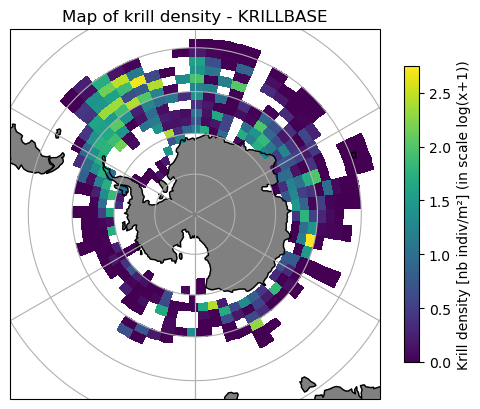

In [9]:
map_proj = ccrs.SouthPolarStereo()

p = krill_base_xarray_largegrid_interpolated["STANDARDISED_KRILL_UNDER_1M2_log"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "viridis"
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill density [nb indiv/m²] (in scale log(x+1))', shrink = 0.8)
plt.title('Map of krill density - KRILLBASE')

Text(0.5, 1.0, 'Map of krill density - KRILLBASE')

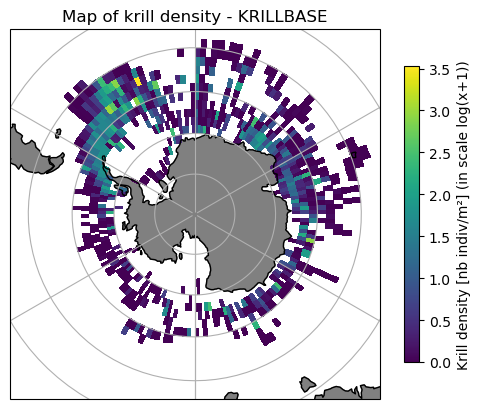

In [10]:
map_proj = ccrs.SouthPolarStereo()

p = krill_base_xarray["STANDARDISED_KRILL_UNDER_1M2_log"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "viridis"
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill density [nb indiv/m²] (in scale log(x+1))', shrink = 0.8)
plt.title('Map of krill density - KRILLBASE')

In [11]:
krill_base_df = krill_base_xarray.to_dataframe()
krill_base_df.describe()

,STANDARDISED_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2_var,STANDARDISED_KRILL_UNDER_1M2_sem,STANDARDISED_KRILL_UNDER_1M2_count,STANDARDISED_KRILL_UNDER_1M2_log
count,715.000000,4.670000e+02,467.000000,715.000000,715.000000
mean,23.930923,1.111277e+05,26.818046,14.324476,0.505953
std,146.617197,1.153915e+06,176.108403,58.771512,0.692829
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000
25%,0.000000,1.233333e-05,0.001833,1.000000,0.000000
50%,0.319000,1.904328e+00,0.665250,2.000000,0.120245
75%,6.773839,6.906643e+02,7.234150,6.000000,0.890629
max,3358.305000,2.255642e+07,3358.305000,749.000000,3.526249


In [12]:
krill_base_largegrid_df = krill_base_xarray_largegrid_interpolated.to_dataframe()
krill_base_largegrid_df.describe()

,STANDARDISED_KRILL_UNDER_1M2,STANDARDISED_KRILL_UNDER_1M2_var,STANDARDISED_KRILL_UNDER_1M2_sem,STANDARDISED_KRILL_UNDER_1M2_count,STANDARDISED_KRILL_UNDER_1M2_log
count,1063.000000,8.480000e+02,848.000000,1063.000000,1063.000000
mean,18.340466,4.592219e+04,16.530754,28.888993,0.563900
std,56.322494,2.722622e+05,54.854209,125.148698,0.692304
min,0.000000,0.000000e+00,0.000000,1.000000,0.000000
25%,0.000000,6.728000e-03,0.034518,2.000000,0.000000
50%,0.530333,8.046883e+00,0.858763,4.000000,0.184786
75%,8.889526,1.559076e+03,8.109756,11.000000,0.995160
max,553.677333,3.221239e+06,552.272929,1329.000000,2.744040


# Variance and standard error of the mean of krill density in KRILLBASE

In [13]:
# Define color sequence
colors =["#d0f0fd", "#d6c06b" , "#f38912"] 
cmap = LinearSegmentedColormap.from_list("blue_purple_red", colors)

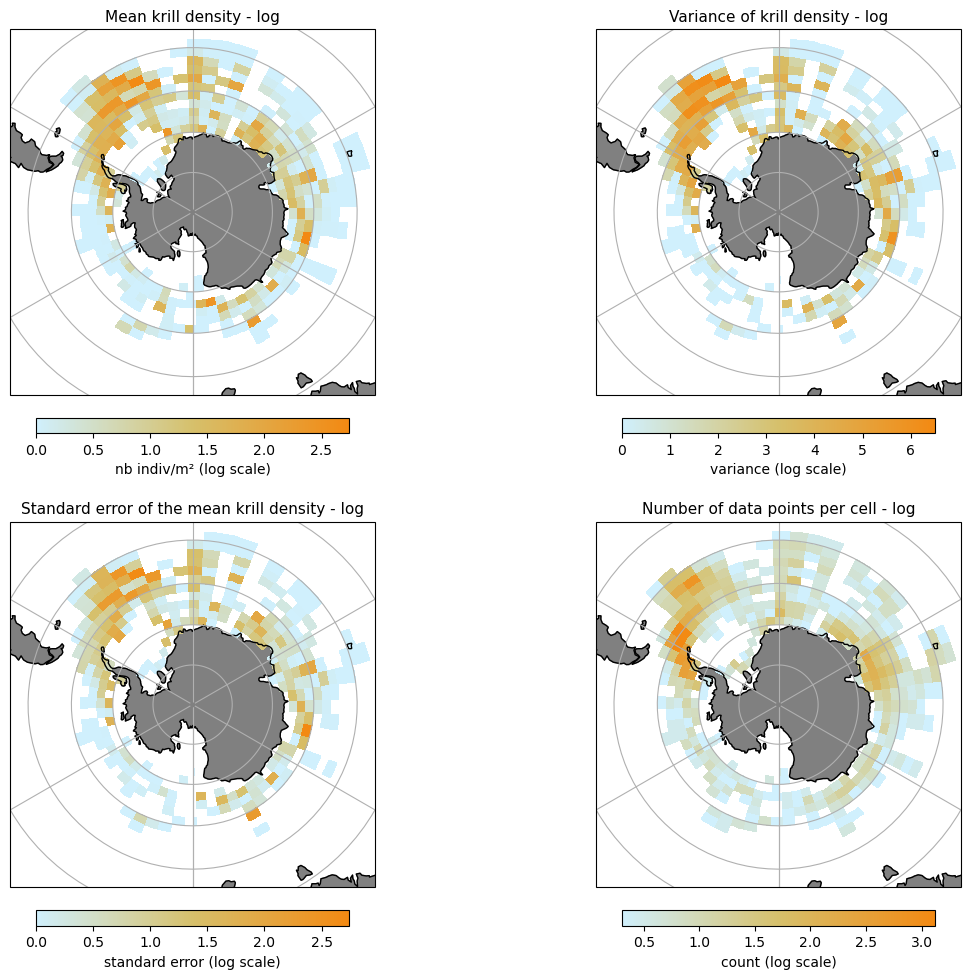

In [14]:
map_proj = ccrs.SouthPolarStereo()
data_proj = ccrs.PlateCarree()

# Créer la figure et les axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': map_proj})
axs = axs.ravel()  # pour itérer plus facilement

# Liste des données à tracer
fields = [
    ("STANDARDISED_KRILL_UNDER_1M2_log", 'Mean krill density - log', 'nb indiv/m² (log scale)', False),
    ("STANDARDISED_KRILL_UNDER_1M2_var", 'Variance of krill density - log', 'variance (log scale)', True),
    ("STANDARDISED_KRILL_UNDER_1M2_sem", 'Standard error of the mean krill density - log', 'standard error (log scale)', True),
    ("STANDARDISED_KRILL_UNDER_1M2_count", 'Number of data points per cell - log', 'count (log scale)', True)
]

for ax, (var, title, label, log_transform) in zip(axs, fields):
    data = krill_base_xarray_largegrid_interpolated[var]
    if log_transform:
        data = my_log(data)

    p = data.plot(
        ax=ax,
        transform=data_proj,
        add_colorbar=False,
        cmap= cmap #"viridis"
    )

    ax.set_title(title, fontsize=11)
    ax.gridlines()
    ax.add_feature(cfeature.LAND, color='grey')
    ax.add_feature(cfeature.COASTLINE)
    
    # Ajouter une colorbar pour chaque subplot
    cb = fig.colorbar(p, ax=ax, orientation='horizontal', shrink=0.4, pad=0.05)
    cb.set_label(label, fontsize=10)

plt.tight_layout()
# plt.savefig('./figures/krillbase_stat_variability.png', bbox_inches = 'tight', dpi=300)

plt.show()

### Relation between the density and the nb of data per cell
Positive relation: more sampling in areas with high krill
(or when sampling, finding more krill...)

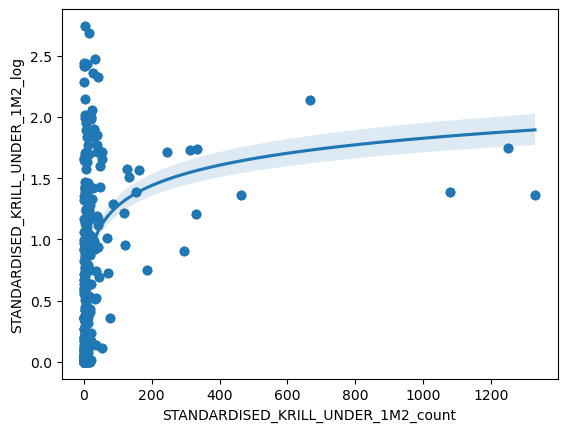

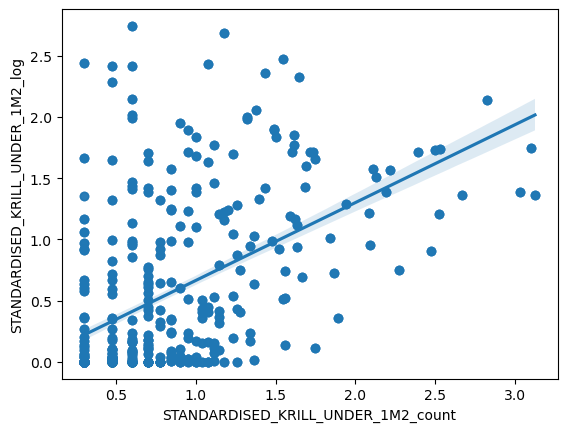

In [15]:
sns.regplot(krill_base_largegrid_df, x='STANDARDISED_KRILL_UNDER_1M2_count', y='STANDARDISED_KRILL_UNDER_1M2_log', logx=True)
plt.show()

sns.regplot(krill_base_largegrid_df, x=np.log10(krill_base_largegrid_df['STANDARDISED_KRILL_UNDER_1M2_count']+1), y='STANDARDISED_KRILL_UNDER_1M2_log')
plt.show()

In [35]:
krill_base_largegrid_df.dropna()#
krill_base_grouped_largegrid[krill_base_grouped_largegrid['STANDARDISED_KRILL_UNDER_1M2_count'] >= 5]
157/358
114/358

0.31843575418994413

In [17]:
krill_base_largegrid_df['STANDARDISED_KRILL_UNDER_1M2_count'].max()

1329.0

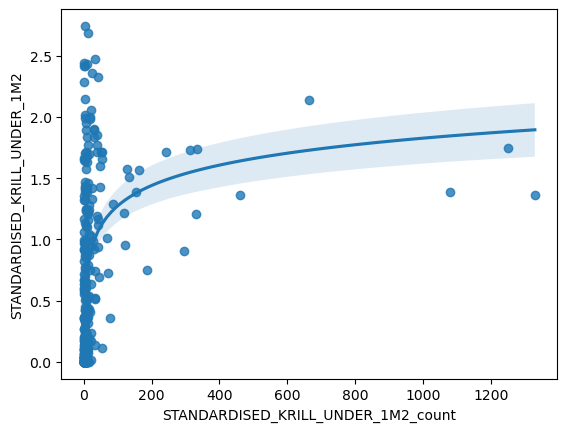

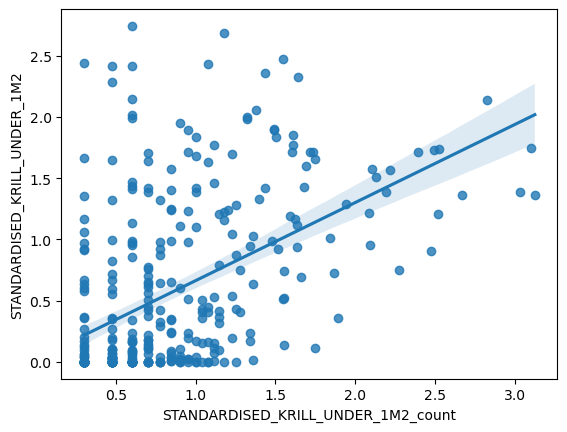

In [27]:
sns.regplot(krill_base_grouped_largegrid, x='STANDARDISED_KRILL_UNDER_1M2_count', y=np.log10(krill_base_grouped_largegrid['STANDARDISED_KRILL_UNDER_1M2']+1), logx=True)
plt.show()

sns.regplot(krill_base_grouped_largegrid, x=np.log10(krill_base_grouped_largegrid['STANDARDISED_KRILL_UNDER_1M2_count']+1), y=np.log10(krill_base_grouped_largegrid['STANDARDISED_KRILL_UNDER_1M2']+1))
plt.show()

## RElation between the variance and the mean : Taylor law
$ Var(Y) = a\times µ^b $ where µ is the mean Mean(Y)

$log(var(Y)) = b\times log(µ) + cste $

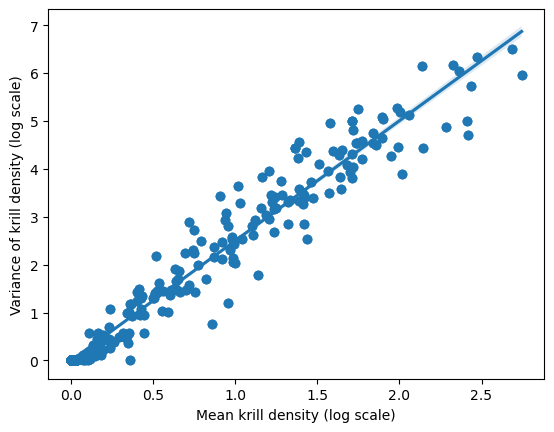

In [18]:
sns.regplot(krill_base_largegrid_df, x='STANDARDISED_KRILL_UNDER_1M2_log', y= np.log10(krill_base_largegrid_df['STANDARDISED_KRILL_UNDER_1M2_var']+1))

plt.xlabel('Mean krill density (log scale)')
plt.ylabel('Variance of krill density (log scale)')
plt.savefig('./figures/krillbase_taylor_law.png', bbox_inches = 'tight', dpi=300)
plt.show()

In [165]:
scipy.stats.linregress(krill_base_largegrid_df.dropna()['STANDARDISED_KRILL_UNDER_1M2_log'], np.log10(krill_base_largegrid_df.dropna()['STANDARDISED_KRILL_UNDER_1M2_var']+1))

LinregressResult(slope=2.506207957675954, intercept=-0.009212659936036927, rvalue=0.97812310843459, pvalue=0.0, stderr=0.01832558591581969, intercept_stderr=0.017751319205437596)

### Save

In [89]:
# Save the dataframe as csv in git hub repo
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/')
krill_base_largegrid_df.to_csv('./outputs_formated_data/Krill_density_krillbase_df_final.csv')

In [90]:
#save files
# save netcdf in local bc too heavy for git hub
krill_base_xarray_largegrid_interpolated.to_netcdf('./outputs_formated_data/Krill_density_krillbase_final.nc')

# Check correlation between the to grids and with krillpodym data

## Compare the two versions of spatial aggregation

In [51]:
krill_base_largegrid_df = krill_base_largegrid_df[krill_base_largegrid_df['STANDARDISED_KRILL_UNDER_1M2_log'] >0]
krill_base_df = krill_base_df[krill_base_df['STANDARDISED_KRILL_UNDER_1M2_log'] >0]

In [52]:

krillbase_test = krill_base_largegrid_df.reset_index().merge(krill_base_df.reset_index(), how='inner', left_on=['LONGITUDE_largegrid','LATITUDE_largegrid'], right_on=['LONGITUDE_ocimgrid','LATITUDE_ocimgrid'])
krillbase_test

,LONGITUDE_largegrid,LATITUDE_largegrid,STANDARDISED_KRILL_UNDER_1M2_x,STANDARDISED_KRILL_UNDER_1M2_log_x,LONGITUDE_ocimgrid,LATITUDE_ocimgrid,STANDARDISED_KRILL_UNDER_1M2_y,STANDARDISED_KRILL_UNDER_1M2_log_y
0,-177,-61,21.669000,1.355432,-177.0,-61.0,21.669000,1.355432
1,-171,-71,0.177667,0.071022,-171.0,-71.0,0.177667,0.071022
2,-169,-65,0.071333,0.029925,-169.0,-65.0,0.214000,0.084219
3,-167,-63,0.164500,0.066139,-167.0,-63.0,0.329000,0.123525
4,-167,-61,0.160000,0.064458,-167.0,-61.0,0.160000,0.064458
...,...,...,...,...,...,...,...,...
436,163,-67,0.568000,0.195346,163.0,-67.0,0.568000,0.195346
437,163,-65,47.317333,1.684103,163.0,-65.0,168.233500,2.228486
438,171,-67,276.159000,2.442729,171.0,-67.0,276.159000,2.442729
439,173,-67,43.235000,1.645766,173.0,-67.0,86.470000,1.941859


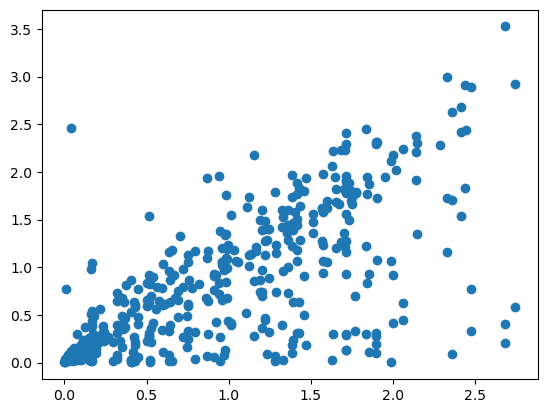

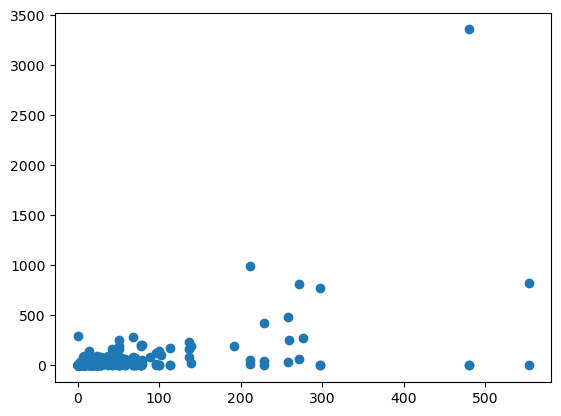

In [53]:
plt.scatter(krillbase_test['STANDARDISED_KRILL_UNDER_1M2_log_x'], krillbase_test['STANDARDISED_KRILL_UNDER_1M2_log_y'])
plt.show()

plt.scatter(krillbase_test['STANDARDISED_KRILL_UNDER_1M2_x'], krillbase_test['STANDARDISED_KRILL_UNDER_1M2_y'])
plt.show()

In [54]:
correlation = krillbase_test['STANDARDISED_KRILL_UNDER_1M2_log_x'].corr(krillbase_test['STANDARDISED_KRILL_UNDER_1M2_log_y'])
correlation 

0.6896544534182856

In [55]:
correlation = krillbase_test['STANDARDISED_KRILL_UNDER_1M2_x'].corr(krillbase_test['STANDARDISED_KRILL_UNDER_1M2_y'])
correlation 

0.51795966963318